# Forecasting the number of bicycle checkout from a bike sharing service using an ARIMA model



### Dataset: 
Number of bicycle checkouts from a bike sharing service.
### Source: 
UCI Machine Learning Repository 

Reference: https://www.datascience.com/blog/stock-price-time-series-arima
### Objective: 
Demonstrate the application for a time series forecasting model (ARIMA) to forecast bicycle checkouts.

### ARIMA:
Auto-Regressive Integrated Moving Average (ARIMA) uses the past values in a regression equation to predict the future.


In [38]:
# Load Libraries
library('ggplot2')
library('forecast')
library('tseries')
library(gridExtra)
library(plotly)


In [39]:
setwd("C:/Users/karaju/Desktop/ML/R_Project/Bike-Sharing-Dataset")
daily_data = read.csv('day.csv', header=TRUE, stringsAsFactors=FALSE)
# Convert to date type
daily_data$Date = as.Date(daily_data$dteday)

## Examine the data

In [64]:
head(daily_data,3)
summary(daily_data$cnt)

instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,Date,clean_cnt,cnt_ma,cnt_ma30
1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01,985,NA,NA
2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02,801,NA,NA
3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03,1349,NA,NA


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     22    3152    4548    4504    5956    8714 

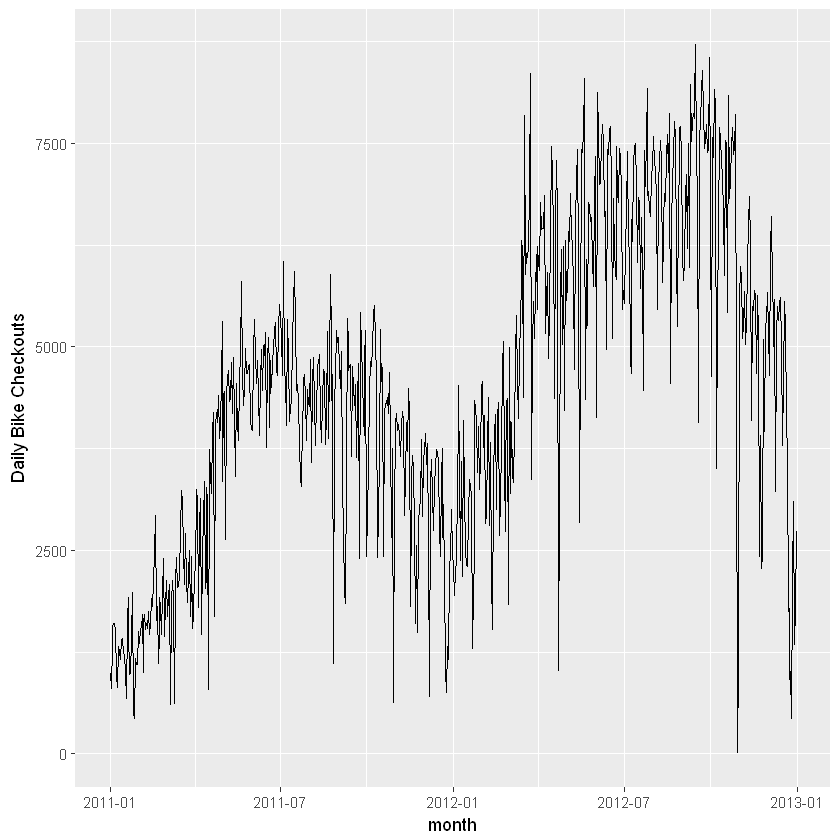

In [40]:
ggplot(daily_data, aes(Date, cnt)) + geom_line() + scale_x_date('month')  + ylab("Daily Bike Checkouts") +
            xlab("")

**Discussion :**
In general there are lots of fluctuations. We can also see some patterns. For example, lower usage of bicycles occurs in the winter months and higher checkout numbers are observed in the summer months.

In some cases, the number of bicycles checked out dropped below 100 on day and rose to over 4,000 the next day. These are suspected outliers that could bias the model by skewing statistical summaries. 

## Replace outliers using series smoothing and decomposition

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


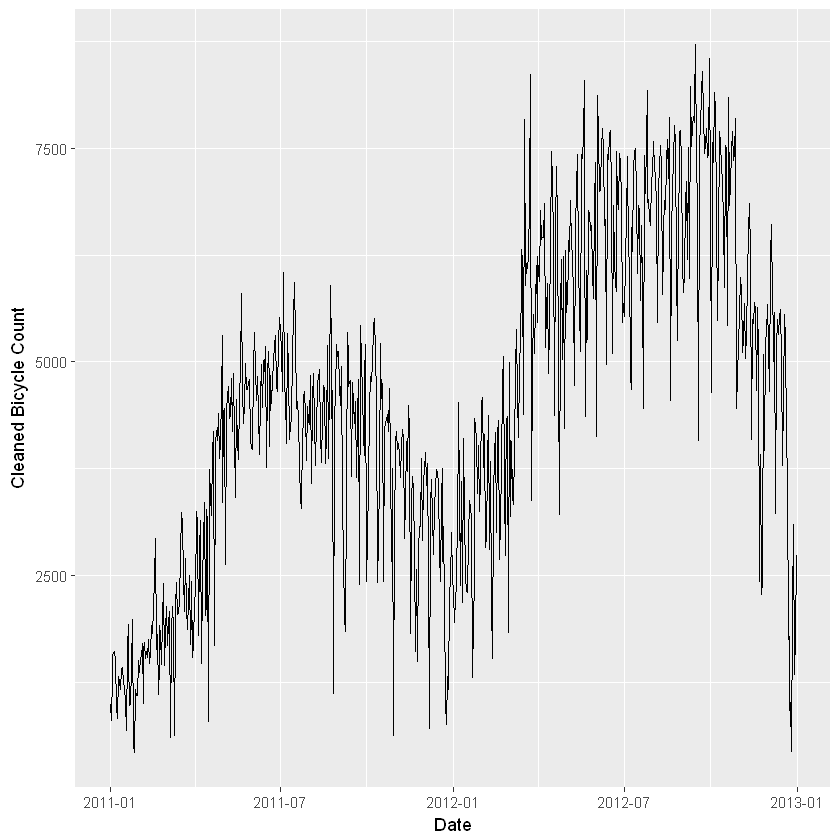

In [41]:
# Create a time series object
count_ts = ts(daily_data[, c('cnt')])

# Remove outliers using series smoothing
daily_data$clean_cnt = tsclean(count_ts)
# plot the time series after removing outliers
ggplot() +
  geom_line(data = daily_data, aes(x = Date, y = clean_cnt)) + ylab('Cleaned Bicycle Count')



**Discussion :**  
Even after removing outliers - data is still volatile.

## Moving Average

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message:
"Removed 6 rows containing missing values (geom_path)."Warning message:
"Removed 30 rows containing missing values (geom_path)."

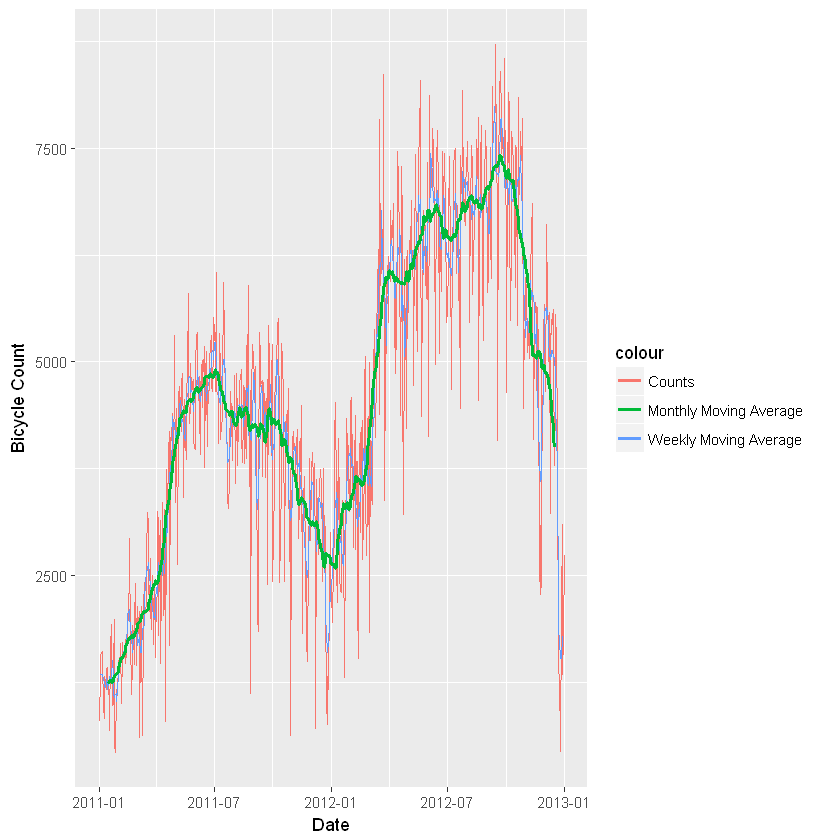

In [42]:
daily_data$cnt_ma = ma(daily_data$clean_cnt, order=7) # using the clean count with no outliers
daily_data$cnt_ma30 = ma(daily_data$clean_cnt, order=30)


ggplot() +
  geom_line(data = daily_data, aes(x = Date, y = clean_cnt, colour = "Counts")) +
  geom_line(data = daily_data, aes(x = Date, y = cnt_ma,   colour = "Weekly Moving Average"))  +
  geom_line(data = daily_data, aes(x = Date, y = cnt_ma30, colour = "Monthly Moving Average"),size = 1)  +
  ylab('Bicycle Count')

**The monthly moving average - smoother series**  
The wider the window of the moving average, the smoother original series becomes.

Modeling daily level data might require specifying multiple seasonality levels, such day of the week, week of the year, month of the year, holidays, etc. For the sake of simplicity, we will model the smoothed series of weekly moving average (as shown by the blue line above).


## Decompose the data - Seasonlaity, Trend & Cycle

[1] 725

[1] 725

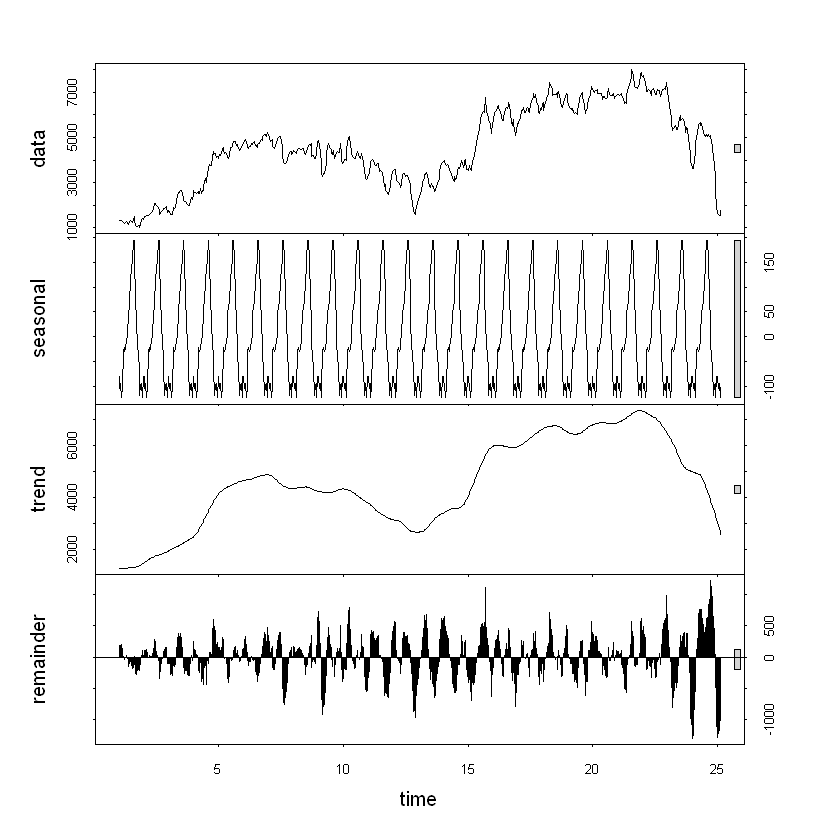

In [47]:
count_ma = ts(na.omit(daily_data$cnt_ma), frequency=30)
length(count_ma)
decomp = stl(count_ma, s.window="periodic")
deseasonal_cnt <- seasadj(decomp)
length(deseasonal_cnt)
plot(decomp)

## Fitting an ARIMA model
Fitting an ARIMA model requires the series to be stationary. 

**Stationarity**  
A series is said to be stationary when its mean, variance, and autocovariance are time invariant.

**Augmented Dickey-Fuller (ADF) Test**  

* The augmented Dickey-Fuller (ADF) test is a formal statistical test for stationarity.
* The null hypothesis assumes that the series is non-stationary.
* ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [44]:
adf.test(count_ma, alternative = "stationary")    

Warning message in adf.test(count_ma, alternative = "stationary"):
"p-value greater than printed p-value"


	Augmented Dickey-Fuller Test

data:  count_ma
Dickey-Fuller = -0.2557, Lag order = 8, p-value = 0.99
alternative hypothesis: stationary


**The bicycle data is non-stationary**
* Non-stationary series can be corrected by a simple transformation such as differencing. 
* Differencing the series can help in removing its trend or cycles. 
* The difference is calculated by subtracting one period's values from the previous period's values.

## Autocorrelations and choosing model order

* Autocorrelatio (ACF) plots display correlation between a series and its lags. 
* Partial autocorrelation plots (PACF), display correlation between a variable and its lags that is not explained by previous lags.


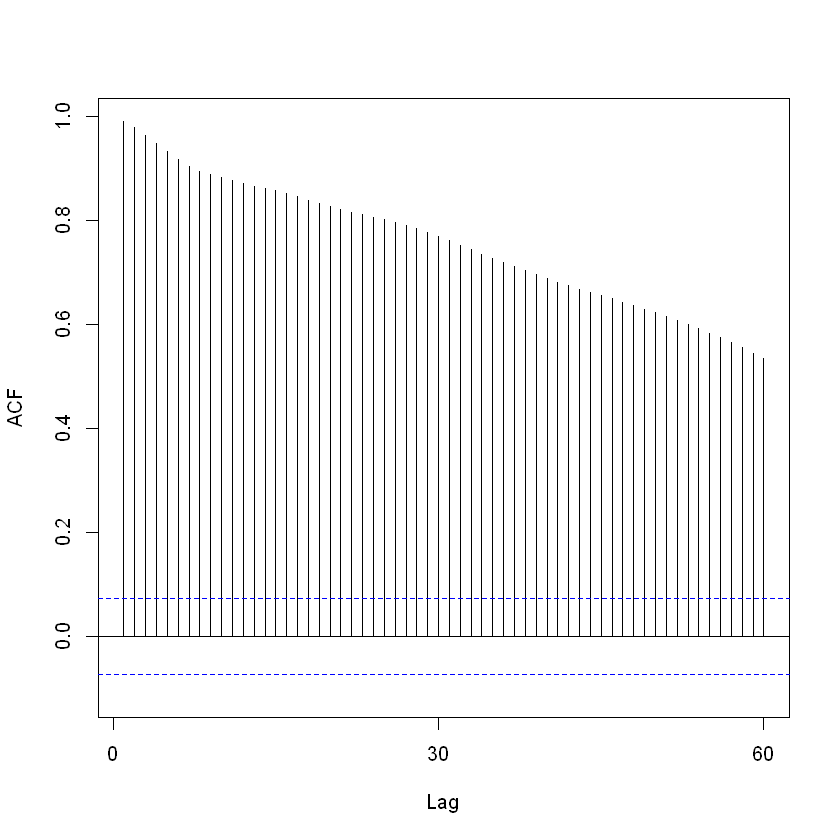

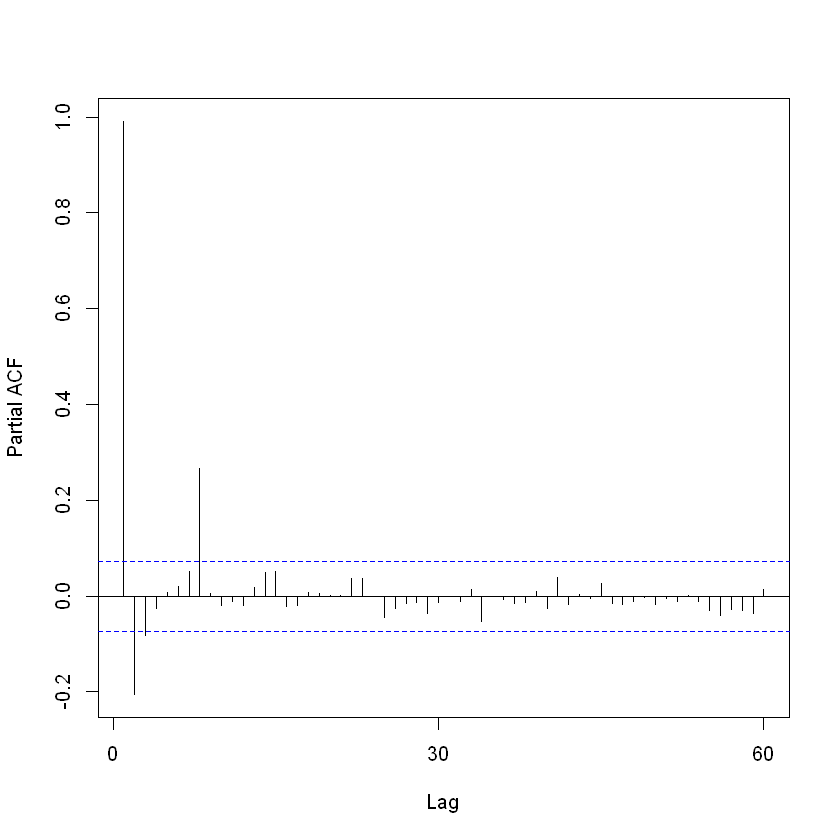

In [21]:
Acf(count_ma, main='')

Pacf(count_ma, main='')

There are significant autocorrelations with many lags in the series, as shown by the ACF plot.
However, this could be due to carry-over correlation from the first or early lags, since the PACF plot only shows a spike at lags 1 and 7.


We can start with the order of d = 1 and re-evaluate whether further differencing is needed.


## First Difference

Warning message in adf.test(count_d1, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  count_d1
Dickey-Fuller = -9.9255, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


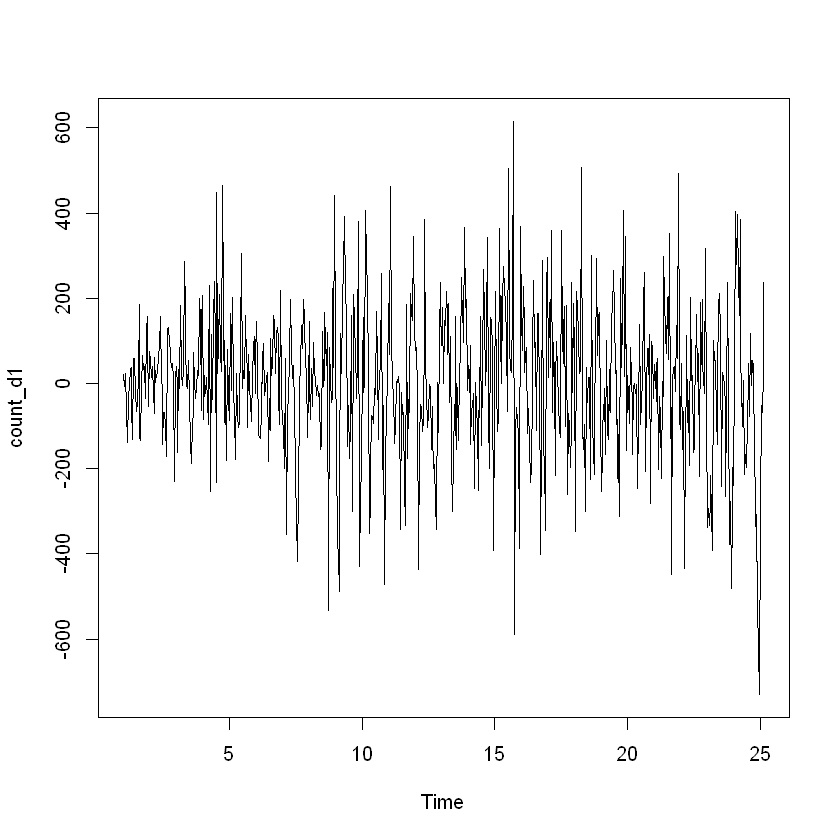

In [52]:
count_d1 = diff(deseasonal_cnt, differences = 1)
plot(count_d1)
adf.test(count_d1, alternative = "stationary")

The augmented Dickey-Fuller test on differenced data rejects the null hypotheses of non-stationarity. Plotting the differenced series, we see an oscillating pattern around 0 with no visible strong trend. This suggests that differencing of order 1 terms is sufficient and should be included in the model. 

## ACF for Differenced Series

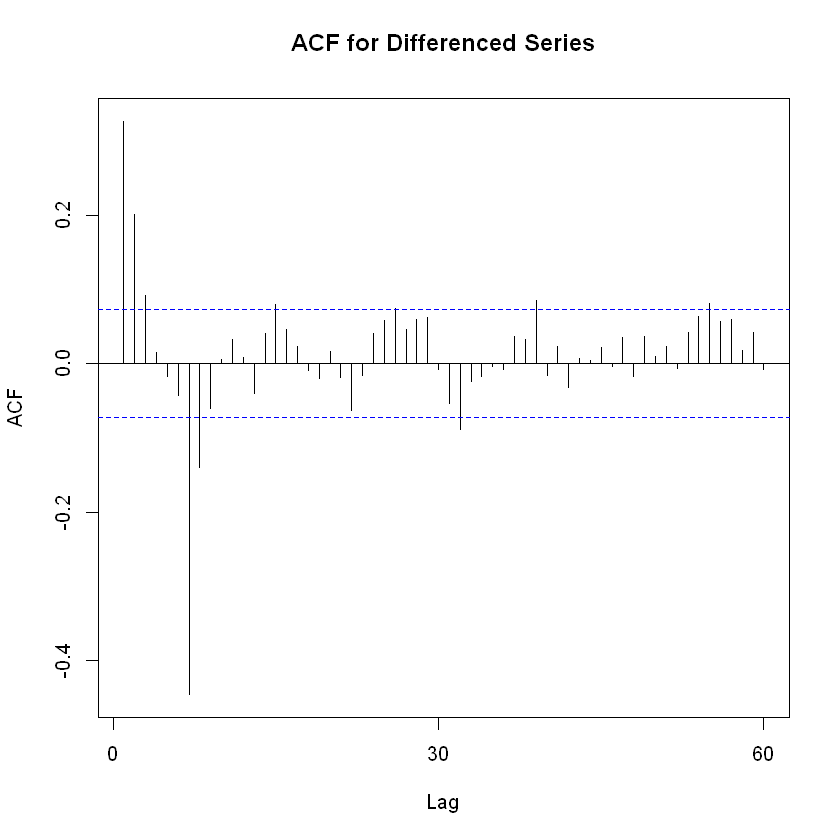

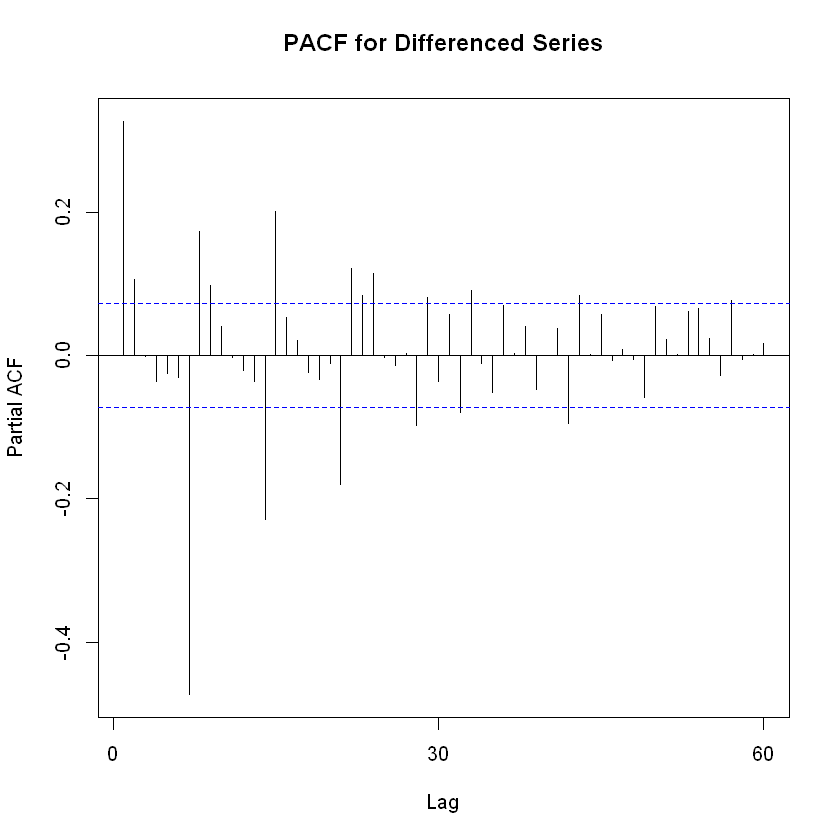

In [24]:
Acf(count_d1, main='ACF for Differenced Series')
Pacf(count_d1, main='PACF for Differenced Series')

* **ACF at lag 1 and 2 => AR(1) or AR(2)**
* **PCF at lag 7 => MA(7)**


There are significant auto correlations at lag 1 and 2 and beyond. Partial correlation plots show a significant spike at lag 1 and 7. This suggests that we might want to test models with AR or MA components of order 1, 2, or 7. A spike at lag 7 might suggest that there is a seasonal pattern present, perhaps as day of the week.

## Fit an ARIMA model
 ARIMA : Auto-Regressive Integrated Moving Average
* Specified by three order parameters: (p, d, q)
* auto.arima() function searches through combinations of order parameters and picks the set that optimizes model fit criteria.
* Criteria for quality of fit:
    * Akaike information criteria (AIC)
    * Baysian information criteria (BIC)
    
* They can be interpreted as an estimate of how much information would be lost if a given model is chosen.
* When comparing models, one wants to minimize AIC and BIC.
    

In [26]:
auto.arima(deseasonal_cnt, seasonal=FALSE)

Series: deseasonal_cnt 
ARIMA(1,1,1) 

Coefficients:
         ar1      ma1
      0.5510  -0.2496
s.e.  0.0751   0.0849

sigma^2 estimated as 26180:  log likelihood=-4708.91
AIC=9423.82   AICc=9423.85   BIC=9437.57

## Evaluate and iterate
## ACF and PACF plots for model residuals

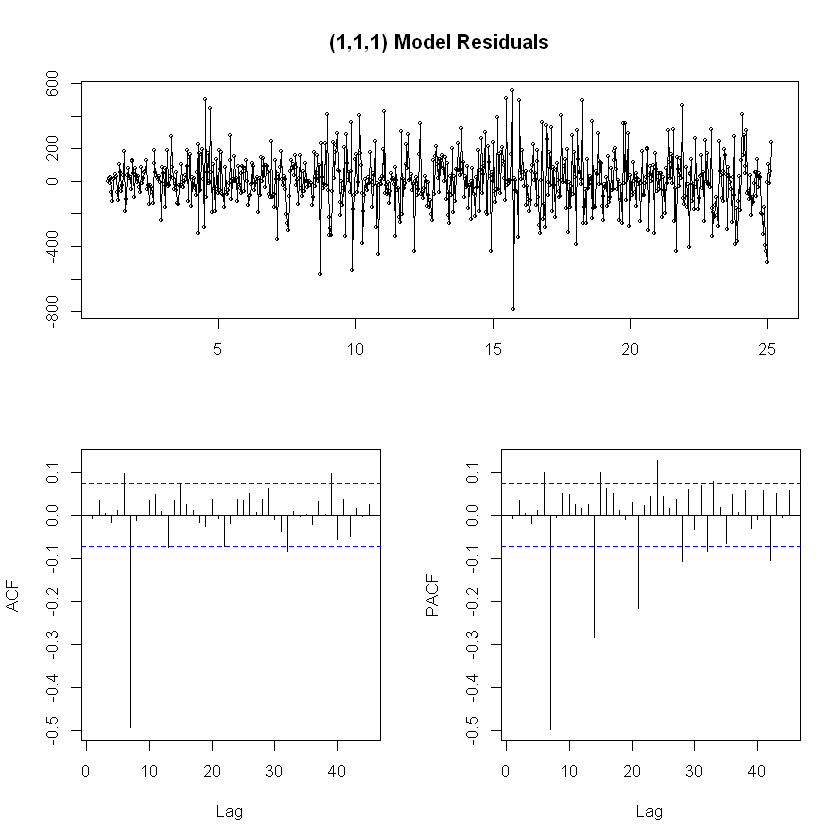

In [27]:
fit<-auto.arima(deseasonal_cnt, seasonal=FALSE)
tsdisplay(residuals(fit), lag.max=45, main='(1,1,1) Model Residuals')

There is a clear pattern present in ACF/PACF and model residuals plots repeating at lag 7. This suggests that the model may be better off with a different specification, such as p = 7 or q = 7. 


Call:
arima(x = deseasonal_cnt, order = c(1, 1, 7))

Coefficients:
         ar1     ma1     ma2     ma3     ma4     ma5     ma6      ma7
      0.2803  0.1465  0.1524  0.1263  0.1225  0.1291  0.1471  -0.8353
s.e.  0.0478  0.0289  0.0266  0.0261  0.0263  0.0257  0.0265   0.0285

sigma^2 estimated as 14392:  log likelihood = -4503.28,  aic = 9024.56

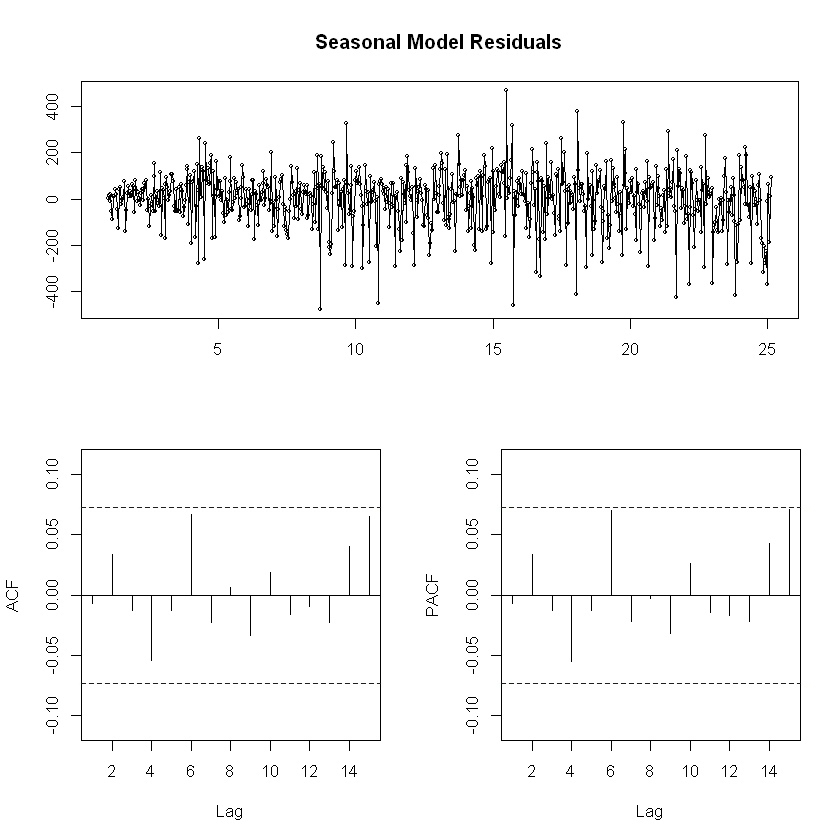

In [30]:
fit2 = arima(deseasonal_cnt, order=c(1,1,7))
fit2
tsdisplay(residuals(fit2), lag.max=15, main='Seasonal Model Residuals')

**Discussion**
* There are no significant autocorrelations present. 
* The residuals look like white noise, meaning they are normally distributed.

## Forecasting Results

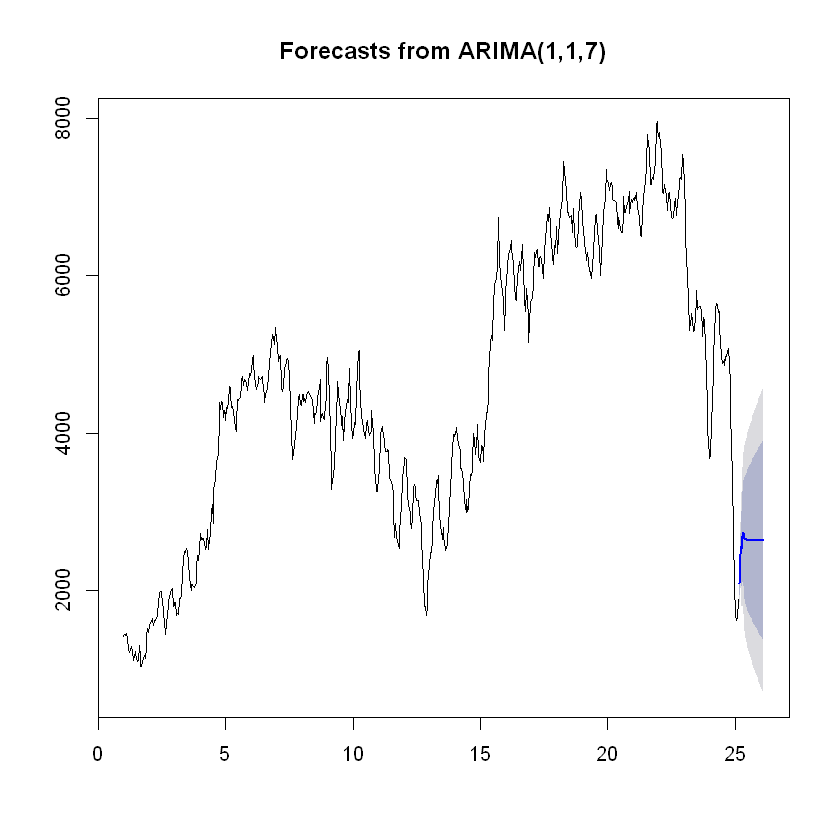

In [31]:
fcast <- forecast(fit2, h=30)
plot(fcast)

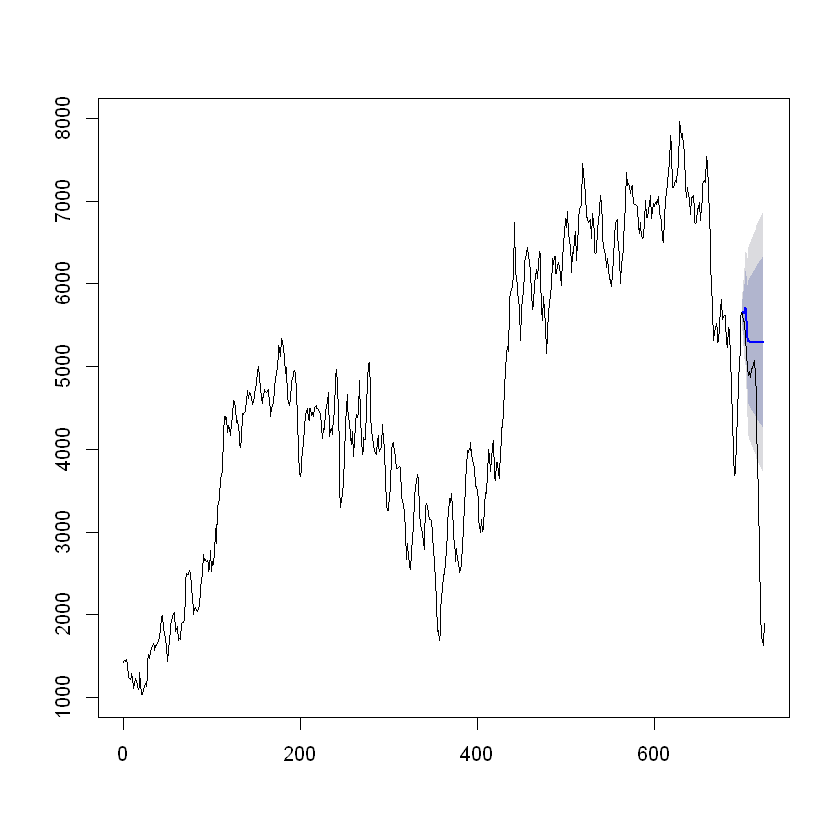

In [32]:
hold <- window(ts(deseasonal_cnt), start=700)

fit_no_holdout = arima(ts(deseasonal_cnt[-c(700:725)]), order=c(1,1,7))

fcast_no_holdout <- forecast(fit_no_holdout,h=25)
plot(fcast_no_holdout, main=" ")
lines(ts(deseasonal_cnt))

* **Blue line - represents forecast**
* **Model assumes no seasonlaity**


## Further Improvements
* The model is assuming a series with no seasonality, and is differencing the original non-stationary data. 
* The plotted predictions are based on the assumption that there will be no other seasonal fluctuations in the data and the change in number of bicycles from one day to another is more or less constant in mean and variance.